In [1]:
from __future__ import print_function
import argparse
import torch
import numpy as np
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.distributions import Normal, Laplace, Independent, Bernoulli, Gamma, Uniform, Beta
from torch.distributions.kl import kl_divergence
import matplotlib.pyplot as plt

In [2]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)
    
class VAE(nn.Module):
    def __init__(self, layers, z_activation_layer, start_beta, p_z, q_z, loss_dist):
        super(VAE, self).__init__()
        if layers[0] is None:
            self.conv_encoder = None
        else:
            self.conv_encoder = nn.Sequential(*layers[0])
            
        if layers[1] is None:
            self.encoder = None
        else:
            self.encoder = nn.Sequential(*layers[1])
            
        if layers[2] is None:
            self.decoder = None
        else:
            self.decoder = nn.Sequential(*layers[2])
            
        if layers[3] is None:
            self.conv_decoder = None
        else:
            self.conv_decoder = nn.Sequential(*layers[3])

        if (len(z_activation_layer[0]) == 0):
            self.z_activation_layer_1 = nn.Sequential()
        else:
            self.z_activation_layer_1 = nn.Sequential(*z_activation_layer[0])
            
        if (len(z_activation_layer[1]) == 0):
            self.z_activation_layer_2 = nn.Sequential()
        else:
            self.z_activation_layer_2 = nn.Sequential(*z_activation_layer[1])
        
        self.beta = start_beta
        self.p_z = p_z
        self.q_z = q_z
        self.loss_dist = loss_dist
        self.x = 0
        self.y = 0
        self.z = 0
        
    def encode(self, x):
        if self.conv_encoder is None:
            x = x.view(-1,784)
            out = self.encoder(x)
        elif self.encoder is None:
            print("nog te doen")
        else:
            out = self.conv_encoder(x)
            self.x, self.y, self.z = out.size(1), out.size(2), out.size(2)
            
            out = out.view(-1, self.x * self.y * self.z)
            out = self.encoder(out)

        length_out = len(out[0]) // 2
        return self.z_activation_layer_1(out[:,:length_out]), self.z_activation_layer_2(out[:,length_out:])

    def reparameterize(self, q_z_given_x):
        return q_z_given_x.rsample()

    def decode(self, z):
        if self.conv_decoder is None:
            x_hat = self.decoder(z)
        elif self.decoder is None:
            print("nog te doen")
        else:
            x_hat = self.decoder(z)
            x_hat = x_hat.view(-1,self.x , self.y , self.z)
            x_hat = self.conv_decoder(x_hat)
            x_hat = x_hat.view(-1,x_hat.size(2) * x_hat.size(3))
        return x_hat
    
    def up_beta(self):
        self.beta += 1
        
    def set_beta(self, beta):
        self.beta = beta
        
    def down_beta(self):
        if self.beta != 0:
            self.beta -= 1

    def forward(self, x):
        mu, logvar = self.encode(x)
        
        q_z_given_x = self.q_z(mu, logvar) # for KL divergence
        q_z_given_x = Independent(q_z_given_x, 1)
        
        z = self.reparameterize(q_z_given_x)
        x_hat = self.decode(z)

        p_x_given_z = self.loss_dist(x_hat) # loss function/ distribution
        p_x_given_z = Independent(p_x_given_z, 1)
        
        loss = self.loss_function(x_hat, x, q_z_given_x, p_x_given_z, z)
        return x_hat, loss
    
    def loss_function(self, x_hat, x,q_z_given_x, p_x_given_z, z):
        x = x.view(-1,784)
        BCE = -p_x_given_z.log_prob(x)
        KLD = q_z_given_x.log_prob(z) - self.p_z.log_prob(z)
        #KLD = kl_divergence(q_z_given_x.base_dist, self.p_z.base_dist) # vervangen en werkend krijgen 
        #KLD = torch.sum(KLD.sum(len(p_z.event_shape)-1))
        return (BCE + self.beta * KLD).mean()

In [3]:
def normal_dist(mu, var):
    return Normal(loc=mu, scale=var)

def laplace_dist(mu, var):
    return Laplace(loc=mu, scale=var)

def gamma_dist(mu, var):
    return Gamma(mu, var)

def beta_dist(mu, var):
    return Beta(mu, var)

def bernoulli_loss(x_hat):
    return Bernoulli(x_hat)

def laplace_loss(x_hat):
    return Laplace(loc=x_hat, scale=1e-2)

def normal_loss(x_hat):
    return Normal(loc=x_hat, scale=1)

In [4]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data
        optimizer.zero_grad()
        x_hat, loss = model(data)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data
            x_hat, loss = model(data)
            test_loss += loss.item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      x_hat.view(128, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [5]:
def load_data(batch_size):
    train_data = datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.ToTensor())
    train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size, shuffle=True, **{})

    test_data = datasets.MNIST('../data', train=False,
                       transform=transforms.ToTensor())
    test_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size, shuffle=True, **{})
    return train_data, train_loader, test_data, test_loader

In [6]:
x_dim = 784#784
z_dim = 2
lr = 1e-3
batch_size = 128
epochs = 5
start_beta = 1
train_data, train_loader, test_data, test_loader = load_data(batch_size)

conv_encoder_layers = [
    nn.Conv2d(1, 20, 5, 1),
    nn.ReLU(True),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(20, 50, 5, 1),
    nn.ReLU(True),
    nn.MaxPool2d(2, 2)
    ]

encoder_layers = [
    nn.Linear(x_dim, 400),
    nn.ReLU(True),
    nn.Linear(400, 40),
    nn.ReLU(True),
    nn.Linear(40, z_dim*2)
    ]

decoder_layers = [
    nn.Linear(z_dim, 40),
    nn.ReLU(True),
    nn.Linear(40, 400),
    nn.ReLU(True),
    nn.Linear(400, x_dim),
    nn.Sigmoid()
    ]

conv_decoder_layers = [
    nn.ConvTranspose2d(50, 20, 5, 1),
    nn.ReLU(True),
    nn.Upsample(scale_factor=3),
    nn.ConvTranspose2d(20, 1, 5, 1),
    nn.ReLU(True),
    nn.Sigmoid()
    ]

# [None, encoder_layers, decoder_layers, None] voor linear zet x_dim naar 784
# [conv_encoder_layers, encoder_layers, decoder_layers, conv_decoder_layers] voor combined zet x_dim naar 800
# [conv_encoder_layers, None, None, conv_decoder_layers] voor combined voor conv nog niet implemented
layers = [None, encoder_layers, decoder_layers, None]
z_activation_layer = [[], [nn.Softplus()]]

# prior
p_z = Normal(loc=torch.zeros(1,z_dim), scale=1)
#p_z = Beta(torch.tensor([0.3, 0.3]), torch.tensor([0.3, 0.3]))
p_z = Independent(p_z,1)

# target distribution
q_z = normal_dist

# loss function
loss_dist = bernoulli_loss

model = VAE(layers, z_activation_layer, start_beta, p_z, q_z, loss_dist)
optimizer = optim.Adam(model.parameters(), lr=lr)
betas = np.arange(0, 1, 0.1)
if __name__ == "__main__":
    for epoch in range(1, epochs + 1):
        train(epoch)
        test(epoch)
        #if epoch <= 10:
        #    model.set_beta(betas[epoch-1])
        #with torch.no_grad():
        #    sample = torch.randn(64, 20)
        #    sample = model.decode(sample)
        #    save_image(sample.view(64, 1, 28, 28),
        #               'results/sample_' + str(epoch) + '.png')


Train Epoch: 1 [0/60000 (0%)]	Loss: 4.247368
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.562719
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.440842
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.384792
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.416037
====> Epoch: 1 Average loss: 1.5101
====> Test set loss: 1.3199
Train Epoch: 2 [0/60000 (0%)]	Loss: 1.328363
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.285904
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1.228263
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.332174
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.258009
====> Epoch: 2 Average loss: 1.2898
====> Test set loss: 1.2643
Train Epoch: 3 [0/60000 (0%)]	Loss: 1.206908
Train Epoch: 3 [12800/60000 (21%)]	Loss: 1.239481
Train Epoch: 3 [25600/60000 (43%)]	Loss: 1.292222
Train Epoch: 3 [38400/60000 (64%)]	Loss: 1.233414
Train Epoch: 3 [51200/60000 (85%)]	Loss: 1.225777
====> Epoch: 3 Average loss: 1.2486
====> Test set loss: 1.2341
Train Epoch: 4 [0/60000 (0%)]	Loss: 1.216415
Train Epoch: 4 [12800/60000 

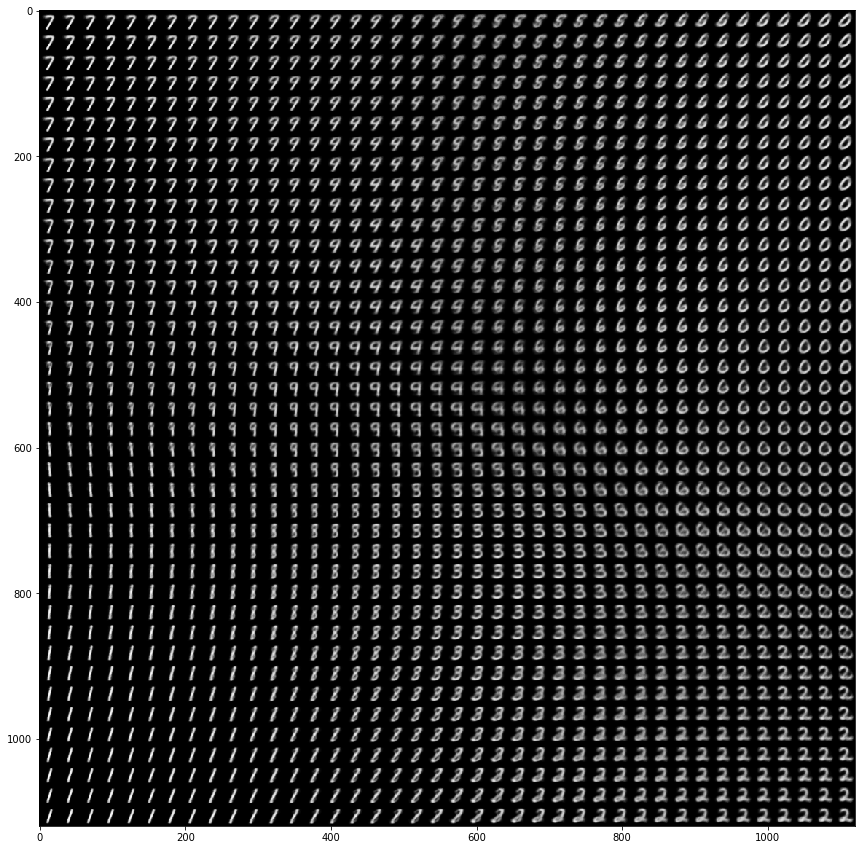

In [7]:
xv = np.arange(-2, 2, .1)
yv = np.arange(-2, 2, .1)
sample = np.zeros([len(yv)*len(xv), 2])
counter = 0
for i in xv:
    for j in yv:
        sample[counter] = [i, j]
        counter += 1

images = model.decode(torch.tensor(sample, dtype=torch.float)).detach().numpy()
image = np.zeros([len(xv)*28, len(yv)*28])
counter = 0
for i in range(len(xv)):
    for j in range(len(yv)):
        image[i*28:i*28+28,j*28:j*28+28] = images[counter].reshape((28,28))
        counter += 1
        
#save_image(torch.tensor(image),'results/sample_test' + str(epoch) + '.png')
plt.figure(figsize=(15,15))
plt.imshow(image, cmap='gray') 
plt.show()

In [71]:
x_dim = 784
z_dim = 2
encoder_layers = [
    nn.Linear(x_dim, 128),
    nn.ReLU(True),
    nn.Linear(128, z_dim*2)
    ]

decoder_layers = [
    nn.Linear(2, 128),
    nn.ReLU(True),
    nn.Linear(128, x_dim)
    ]
print(encoder_layers)

[Linear(in_features=784, out_features=128, bias=True), ReLU(inplace), Linear(in_features=128, out_features=4, bias=True)]


In [128]:
encoder_layers = [
    nn.Linear(x_dim, 400),
    nn.ReLU(True),
    nn.Linear(400, 40),
    nn.ReLU(True),
    nn.Linear(40, z_dim*2)
    ]

decoder_layers = [
    nn.Linear(z_dim, 40),
    nn.ReLU(True),
    nn.Linear(40, 400),
    nn.ReLU(True),
    nn.Linear(400, x_dim),
    nn.Sigmoid()
    ]

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])